# Multi-task model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
import CCLE_utils
import MMRF_utils
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import polyfit

## Load encoded cell line data

In [2]:
with pd.HDFStore('normalized_embeddings.h5') as store:
    print(store.keys())

['/ccle_test_ccleae', '/ccle_test_combinedae', '/ccle_test_mmrfae', '/ccle_train_ccleae', '/ccle_train_combinedae', '/ccle_train_mmrfae', '/ccle_valid_ccleae', '/ccle_valid_combinedae', '/ccle_valid_mmrfae', '/mmrf_test_ccleae', '/mmrf_test_combinedae', '/mmrf_test_mmrfae', '/mmrf_train_ccleae', '/mmrf_train_combinedae', '/mmrf_train_mmrfae', '/mmrf_valid_ccleae', '/mmrf_valid_combinedae', '/mmrf_valid_mmrfae']


In [26]:
X_train = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_train_mmrfae', index_col=1)
X_train = X_train.set_index(X_train.iloc[:, 0])
X_train = X_train.iloc[: , 1:]

X_val = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_valid_mmrfae', index_col=1)
X_val = X_val.set_index(X_val.iloc[:, 0])
X_val = X_val.iloc[: , 1:]

X_test = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_test_mmrfae', index_col=1)
X_test = X_test.set_index(X_test.iloc[:, 0])
X_test = X_test.iloc[: , 1:]

In [4]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.set_index(['DepMap_ID'])
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]

In [32]:
geneNames = [x.split()[0] for x in list(crispr.columns)]

In [37]:
train_index = list(set(X_train.index).intersection(crispr.index))
val_index = list(set(X_val.index).intersection(crispr.index))
test_index = list(set(X_test.index).intersection(crispr.index))

In [38]:
# list(X_train.index)
X_train = np.array(X_train.loc[train_index])
Y_train = np.array(crispr.loc[train_index])

X_val = np.array(X_val.loc[val_index])
Y_val = np.array(crispr.loc[val_index])

X_test = np.array(X_test.loc[test_index])
Y_test = np.array(crispr.loc[test_index])



In [39]:
X_train.shape

(559, 128)

In [40]:
Y_train[:,1].shape

(559,)

# Linear regression for each KO gene

In [35]:
def plot_pred(y_train, y_train_pred, y_test, y_test_pred,geneNames, i):
    y_train = y_train[:,i]
    y_test = y_test[:,i]

    fig, ax = plt.subplots(1,1)
    ax.scatter(y_train,y_train_pred, label='Train', color='#4287f5')
    ax.scatter(y_test,y_test_pred, label='Test', color='#f2797f')
    
    rTrain = np.corrcoef(y_train, y_train_pred)[0,1]
    rTest = np.corrcoef(y_test, y_test_pred)[0,1]
    
    bTrain, mTrain = polyfit(y_train, y_train_pred, 1)
    ax.plot(y_train,bTrain+mTrain*y_train, label='r = '+str(round(rTrain,2)), color='#4287f5')

    bTest, mTest = polyfit(y_test, y_test_pred, 1)
    ax.plot(y_test,bTest+mTest*y_test, label='r = '+str(round(rTest,2)), color='#f2797f')
        
    ax.set_xlabel('True Response')
    ax.set_ylabel('Predicted Response')
    ax.legend()
    ax.set_title('CRISPR Knockout Experiment '+str(geneNames[i]))

In [34]:
def make_reg(X_train, Y_train, X_test, Y_test, geneNames, i):
    reg = LinearRegression().fit(X_train, Y_train[:,i])
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    
    plot_pred(Y_train, y_train_pred, Y_test, y_test_pred,geneNames, i)

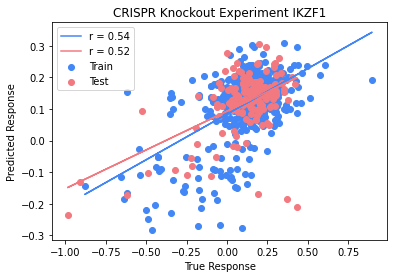

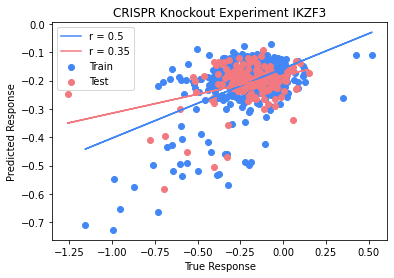

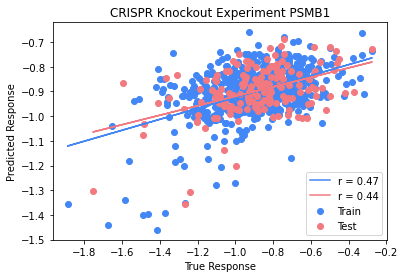

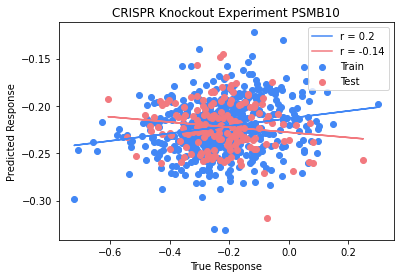

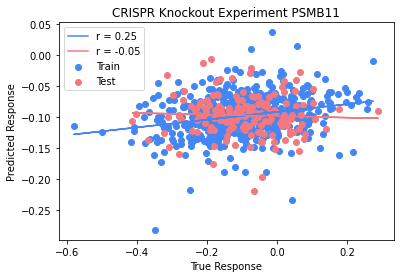

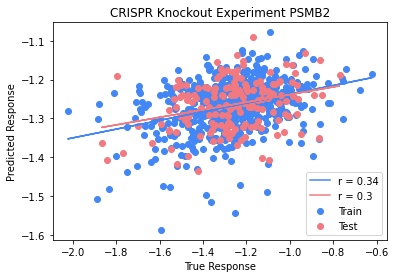

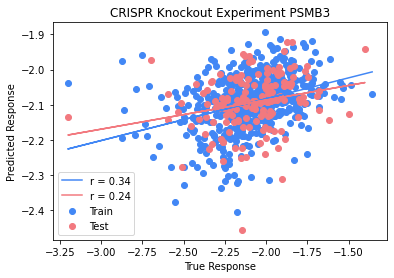

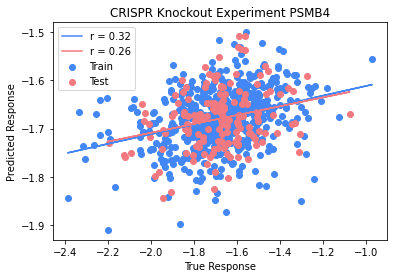

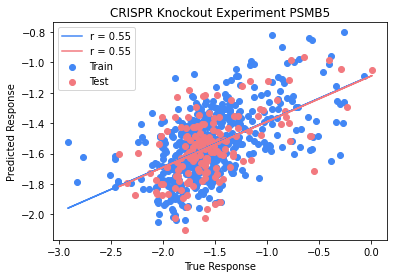

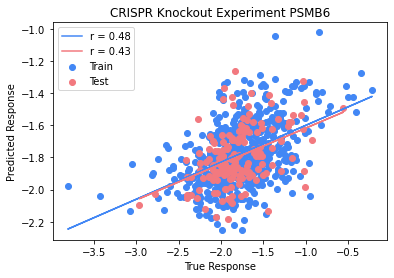

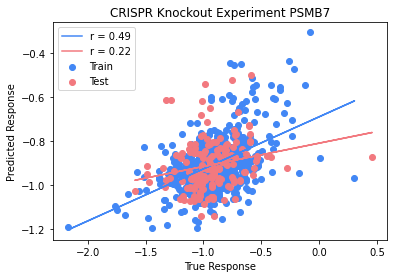

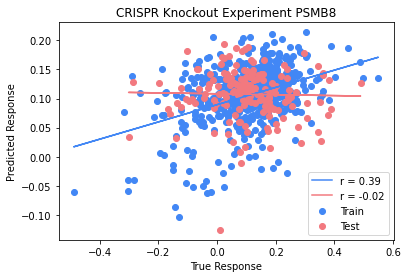

In [42]:
for i in range(12):
    make_reg(X_train, Y_train, X_test, Y_test,geneNames,i)